<a href="https://colab.research.google.com/github/supertime1/Floyer_Analysis/blob/main/Cosinuss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
sys.path.append('C:/Users/57lzhang.US04WW4008/PycharmProjects/cosinuss')

In [3]:
from data_container import config, DataFile
from data_container.importer import Importer
import matplotlib.pyplot as plt
import numpy as np

2021-02-18 10:05:18 - DEBUG -       dc_config:  45 - DcConfig initialized


In [5]:
config.init(db_name='sonova_analysis')
imp = Importer(username='sonova.fremont.api',
               server = 'https://telecovid.earconnect.de')
# password: teeshau7aiMonoh9ee

2021-02-18 10:05:37 - ERROR -       dc_config:  52 - data_container.config.init() can only be called once
2021-02-18 10:05:37 -  INFO -       api_login: 241 - login: sonova.fremont.api @ https://telecovid.earconnect.de
2021-02-18 10:05:38 -  INFO -       api_login: 253 - successful login, it expires 2021-02-18 22:05:38 expiring in 720.0 min


In [10]:
# download data if it is not in local database
#df_cshell = imp.pull_df('8QEK89R9B4.2NTSXK')

#import cShell data
df_cshell = DataFile.objects(_hash_id='8QEK89R9B4.2NTSXK').first()
cshell = imp.one3_hr_algo('v0', '8QEK89R9B4.2NTSXK')
cshell.keys()
cs_hr_x = np.asarray(cshell['heart_rate_t'])
cs_hr_y = cshell['heart_rate']
cd_q = cshell['quality']

In [15]:
#import polar data
df_ploar = imp.pull_df('003RN9.36G4ZN')

df_polar = DataFile.objects(_hash_id='003RN9.36G4ZN').first()
po_hr_x = df_polar.c.heart_rate.x
po_hr_y = df_polar.c.heart_rate.y
offset = (df_cshell.date_time_start - 
          df_polar.date_time_start).total_seconds() + 2098

2021-02-18 10:22:19 -  INFO -     api_db_sync: 429 - Data file 003RN9.36G4ZN completely downloaded + database_entries: Scope, Config, Projects (4), Receivers (3), Persons (27), Devices (4)User (6), 


In [45]:
new = np.asarray([round(i) for i in po_hr_x])

In [46]:
new

array([   5,    6,    7, ..., 5317, 5318, 5319])

In [47]:
cs_hr_x

array([   7,    8,    9, ..., 1605, 1606, 1607])

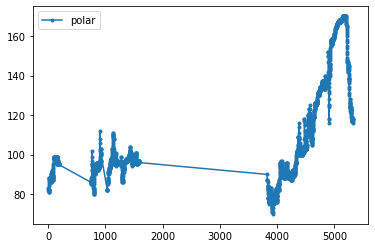

In [31]:
plt.plot(po_hr_x[100], po_hr_y, marker='.', label='polar')
#plt.plot(cs_hr_x+offset, cs_hr_y, marker='.', label='cshell')
plt.legend()
plt.show()

In [ ]:
#convert time to seconds in integer
#fill
class PairedSample:
    
    def __init__(self, polar_hash_id, floyer_hash_id, hr_algo_version):
        self.polar_hash_id = polar_hash_id
        self.floyer_hash_id = floyer_hash_id
        self.df_polar = DataFile.objects(_hash_id=polar_hash_id).first()
        self.df_floyer = DataFile.objects(_hash_id=floyer_hash_id).first()
        self.hr_algo_version = hr_algo_version
    
    def process(self):
        # calculate floyer heart rate
        floyer = imp.one3_hr_algo(self.hr_algo_version, self.floyer_hash_id)
        floyer_hr_x = np.asarray(floyer['heart_rate_t'])
        floyer_hr_y = floyer['heart_rate']

        # get polar heart rate 
        po_hr_x = self.df_polar.c.heart_rate.x
        po_hr_y = self.df_polar.c.heart_rate.y

        # calculate offsets (i.e. floyer and polar maynot start recording at the
        # same time)
        offset = (df_cshell.date_time_start - 
                  df_polar.date_time_start).total_seconds() + 2098
        # make sure two devices start at the same time
        po_hr_x = po_hr_x[offset:]
        po_hr_y = po_hr_y[offset:]

        # create a new dataframe with three columns: time (s), p_hr, f_hr
        


        self.mape = self.mape() 
        self.icc = self.icc()
        self.da = self.da()

    def mape(self):
    
    def icc(self):
    
    def da(self):

    def line_plot(self):

    def ba_plot(self):

    